In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from bo_methods_lib.bo_functions_generic import find_train_doc_path
import bo_methods_lib
from bo_methods_lib.bo_functions_generic import gen_theta_set

from bo_methods_lib.CS2_bo_plotters import plot_obj_abs_min, value_plotter, plot_obj, plot_Theta, plot_Theta_min, path_name, plot_org_train, save_fig, plot_EI_abs_max

from bo_methods_lib.CS2_bo_functions_multi_dim import set_ep

from bo_methods_lib.GP_Validation_Debug import LOO_Plots_2_Input, LOO_Plots_3_Input, LOO_parity_plot_emul,path_name_gp_val

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# DateTime = "2022/10/21/13-05" #Date and Time - Dispayed in job file
# DateTime = "2022/10/21/13-18" #Date and Time - Dispayed in job file
DateTime = "2023/1/27/12-00" #Date and Time - Dispayed in job file
DateTime = "2023/1/23/13-45" #Date and Time - Dispayed in job file
# DateTime = "2022/12/16/16-07" #Date and Time - Dispayed in job file
# DateTime = "2023/1/3/15-07" #Date and Time - Dispayed in job file
# DateTime = None

emulator = True
obj = "obj"
normalize = False

Case_Study = 2.2
d = 8

exp_d = 2
n = 17 #Number of experimental data points to use

param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
              4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
indecies = [list(param_dict.keys())[list(param_dict.values()).index('a_1')],
            list(param_dict.keys())[list(param_dict.values()).index('a_2')]]

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

Theta_True = Constants[1:3].flatten()

bounds = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])

param_names_list = [param_dict[0], param_dict[1]] #Fill in depending on problem
mesh_combo = str(param_names_list[0]) + "-" + str(param_names_list[1])

set_lengthscale = None
save_CSV = False

t = 200
plot_num = int(t/2)
if emulator == True:
    t = n*t

print(t)
#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]
m = Xexp.shape[1]

is_figure = False
save_figure = False
save_csv = False

3400


In [3]:
fxn = "LOO_parity_plot_emul"
plot_axis = 0
csv_end_model = "/sse_model.npy"
csv_end_sim = "/sse_sim.npy"
csv_end_stdev = "/sse_gp_stdev.npy"
path_model = path_name_gp_val(emulator, fxn, set_lengthscale, t, obj, Case_Study, DateTime, is_figure, csv_end_model, 
                              plot_axis, plot_num, normalize)
path_sim = path_name_gp_val(emulator, fxn, set_lengthscale, t, obj, Case_Study, DateTime, is_figure, csv_end_sim, 
                            plot_axis, plot_num, normalize)
path_stdev = path_name_gp_val(emulator, fxn, set_lengthscale, t, obj, Case_Study, DateTime, is_figure, csv_end_stdev, 
                            plot_axis, plot_num, normalize)
GP_mean = np.load(path_model)
y_sim = np.load(path_sim)
GP_stdev = np.load(path_stdev)
print("GP Mean: \n",GP_mean)

all_data_doc = find_train_doc_path(emulator, obj, d, t)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
test_data_to_plot = all_data[int(plot_num*n)] 
title_arg = test_data_to_plot[1:-m-1]

error = (GP_mean - y_sim)**2
argmin = np.argmax(error)
X_worst = np.array([Xexp[argmin]])
print("\n Xexp corresponding to worst prediction: \n", X_worst)

GP Mean: 
 [-1.73490353e+01 -3.15816040e+03 -2.02326465e+04 -4.88682652e+00
 -6.31898880e+01 -2.07764664e+01 -1.16240283e+03 -1.03082180e+01
 -1.42095108e+02 -6.22404175e+01 -9.74126434e+01 -1.00911270e+02
 -1.54842560e+02 -1.22342018e+02 -1.29826584e+02 -5.60905304e+01
 -4.52613373e+01]

 Xexp corresponding to worst prediction: 
 [[-1.42901866  0.27115497]]


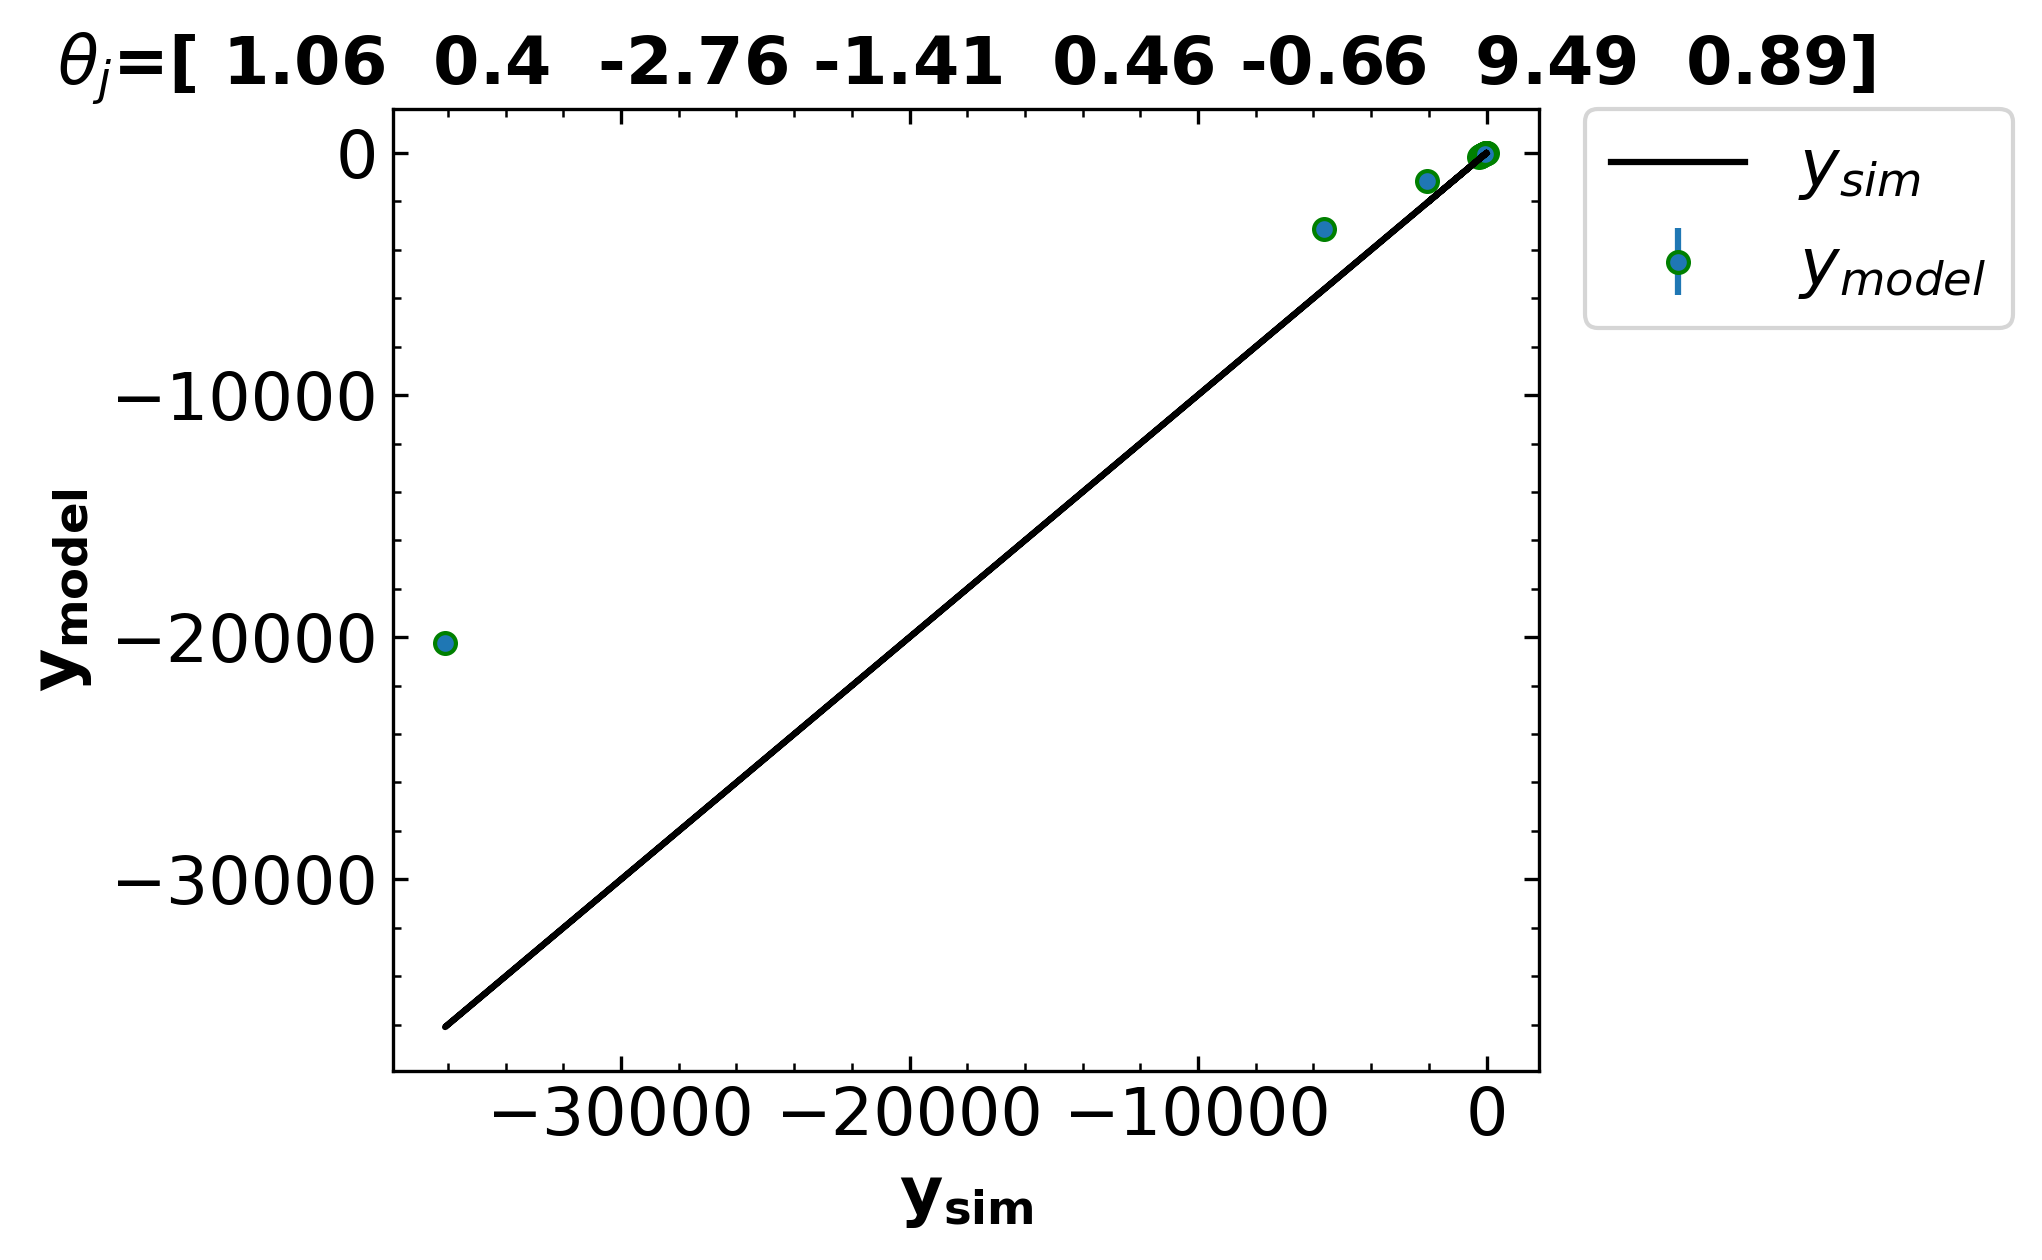

In [4]:
LOO_parity_plot_emul(GP_mean, y_sim, GP_stdev, Case_Study, DateTime, t, emulator, obj, set_lengthscale, save_figure, plot_axis, plot_num, title_arg, save_csv, normalize)

In [5]:
def value_plotter_CS2_simple(test_mesh, z, minima, saddle, title, X_train = None, X_bad = False):
    '''
    Plots heat maps for 2 input GP
    Parameters
    ----------
        test_mesh: ndarray, 2 NxN uniform arrays containing all values of the 2 input parameters. Created with np.meshgrid()
        z: ndarray or tensor, An NxN Array containing all points that will be plotted
        p_true: ndarray, A 2x1 containing the true input parameters
        p_GP_Opt: ndarray, A 2x1 containing the optimal input parameters predicted by the GP
        p_GP_Best: ndarray, A 2x1 containing the input parameters predicted by the GP to have the best EI
        title: str, A string containing the title of the plot
        title_save: str, A string containing the title of the file of the plot
        obj: str, The name of the objective function. Used for saving figures
        ep: int or float, the exploration parameter
        emulator: True/False, Determines if GP will model the function or the function error
        sparse_grid: True/False, True/False: Determines whether a sparse grid or approximation is used for the GP emulator
        set_lengthscale: float or None, The value of the lengthscale hyperparameter or None if hyperparameters will be updated at training
        save_figure: True/False, Determines whether figures will be saved
        Bo_iter: int or None, Determines if figures are save, and if so, which iteration they are
        run, int or None, The iteration of the number of times new training points have been picked
     
    Returns
    -------
        plt.show(), A heat map of test_mesh and z
    '''
    xx , yy = test_mesh #NxN, NxN
    #Assert sattements
    assert isinstance(z, np.ndarray)==True or torch.is_tensor(z)==True, "The values in the heat map must be numpy arrays or torch tensors."
    assert xx.shape==yy.shape, "Test_mesh must be 2 NxN arrays"
    assert z.shape==xx.shape, "Array z must be NxN"
    assert isinstance(title, str)==True, "Title must be a string" 
    
    #Set plot details
#     plt.figure(figsize=(8,4))
    plt.contourf(xx, yy,z, levels = 1000, cmap = "jet")
    plt.colorbar()
    
    #plot saddle pts and local minima, only label 1st instance
    for i in range(len(minima)):
        if i == 0:
            plt.scatter(minima[i,0], minima[i,1], color="black", label = "Minima", s=25, marker = (5,1))
        else:
            plt.scatter(minima[i,0], minima[i,1], color="black", s=25, marker = (5,1))
    
    for j in range(len(saddle)):
        if j == 0:
            plt.scatter(saddle[j,0], saddle[j,1], color="white", label = "Saddle", s=25, marker = "x")
        else:
            plt.scatter(saddle[j,0], saddle[j,1], color="white", s=25, marker = "x")
    if str(X_train) != "None":
        plt.scatter(X_train[:,0], X_train[:,1], color = "brown", label = "Training", marker = "o")
        
    if X_bad.any() != False:
        plt.scatter(X_bad[:,0], X_bad[:,1], color = "green", label = "Worst", marker = "*")
        
    
    #Plots axes such that they are scaled the same way (eg. circles look like circles)
    plt.axis('scaled')    
    
    #Plots grid and legend
#     plt.grid()
    plt.legend(loc = 'upper left')

    #Creates axis labels and title
    plt.xlabel('$x_1$',weight='bold')
    plt.ylabel('$x_2$',weight='bold')
    plt.xlim((np.amin(xx), np.amax(xx)))
    plt.ylim((np.amin(yy),np.amax(yy)))
    plt.title("Heat Map of "+title, weight='bold',fontsize=16)
           
    return plt.show() 

def calc_Muller_PE(Constants, X_mesh):
    #Initialize Muller_PE_Matrix
    Muller_Mat = np.zeros((X_mesh.shape[1:3]))
    #loop over x1
    for i in range(X_mesh.shape[1]):
        #Loop over X2
        for j in range(X_mesh.shape[2]):
            #Sum to get Energy Surface
            A, a, b, c, x0, y0 = Constants
            X1 = X_mesh[0,i,j]
            X2 = X_mesh[1,i,j]
            Term1 = a*(X1 - x0)**2
            Term2 = b*(X1 - x0)*(X2 - y0)
            Term3 = c*(X2 - y0)**2
            Muller_Mat[i,j] = np.sum(A*np.exp(Term1 + Term2 + Term3))
    return Muller_Mat
print(title_arg)

[ 1.0559737   0.40139373 -2.76095575 -1.41074998  0.46000764 -0.66289177
  9.48715275  0.89008057]


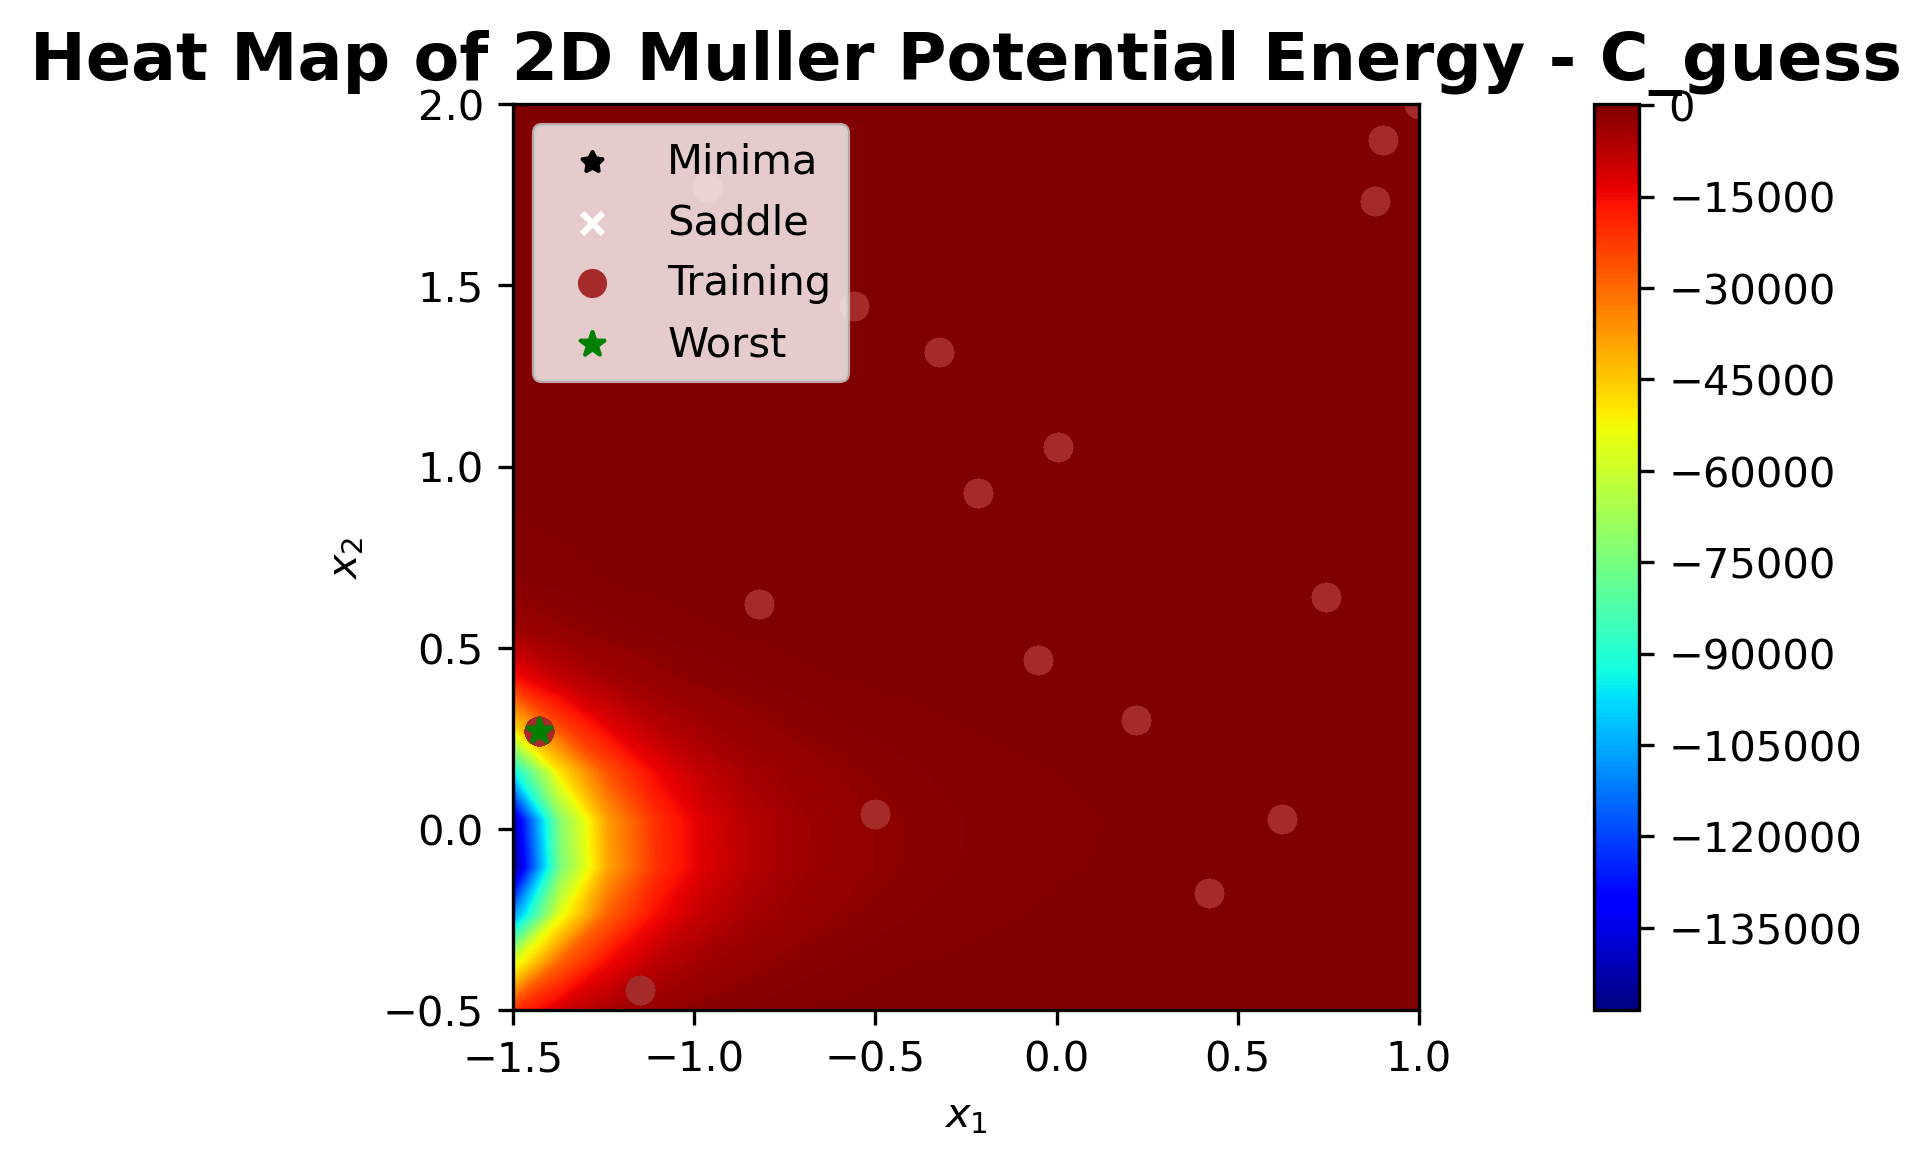

In [6]:
#Plot

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

Constants1 = np.array([[-200,-100,-170,15],
                       [-1.51378345,  1.53159478, -8.33387947, -0.48137312],
                       [-0.33090346, -0.29695468, 5.12578288, -1.13861214],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]]) #TP = 20

Constants2 = np.array([[-200,-100,-170,15],
                       [1.83638528, -0.53160937, -6.44197486, -1.49254272],
                       [0.36545315,  1.63832118,  9.38197704, -1.15573466],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]]) #TP = 100

Constants3 = np.array([[-200,-100,-170,15],
                       [-0.47049549, -1.05388048, -0.73292684, -1.08858067],
                       [-0.82845454, -0.73231573, 7.5886997, 1.62072441],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]]) #TP = 40

Constants4 = np.array([[-200,-100,-170,15],
                       [1.0559737,   0.40139373, -2.76095575, -1.41074998],
                       [0.46000764, -0.66289177, 9.48715275,  0.89008057],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]]) #TP = 200


minima = np.array([[-0.558,1.442],
                  [-0.050,0.467],
                  [0.623,0.028]])

saddle = np.array([[-0.82,0.62],
                  [0.22,0.30]])

p=20
X1 =  np.linspace(-1.5,1,p) #1x10
X2 =  np.linspace(-0.5,2,p) #1x10
X_mesh = np.array(np.meshgrid(X1, X2)) #2 Uniform 5x5 arrays

all_data_doc = '/scratch365/mcarlozo/Toy_Problem/' + find_train_doc_path(True, "obj", 8, t)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=","))
X_train = all_data[:, -3:-1] 
# print(X_train.shape)
title = "2D Muller Potential Energy - C_guess"
Muller_Mat = calc_Muller_PE(Constants4, X_mesh)
value_plotter_CS2_simple(X_mesh, Muller_Mat, minima, saddle, title, X_train, X_worst)